In [39]:
#loading necessary packages
options(scipen=999)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(VennDiagram))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(rtracklayer))
suppressPackageStartupMessages(library(rtracklayer))
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(liftOver))

## Calculating correlation between chi-square and LD-scores of ancestry specific meta-analysis

#### The LD-scores for EAS, AFR, AMR and SAS were sourced from https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-024-10293-3

#### We then transformed the genomic coordinates from hg38 to hg19

In [16]:
# Define ancestries
ancestries <- c("EAS", "SAS", "AFR", "AMR")

# Define path to chain file for liftover
#path <- system.file(package = "liftOver", "extdata", "hg38ToHg19.over.chain")
ch <- import.chain("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/polygenicity_estimate/liftover/hg38ToHg19.over.chain")

# Loop through each ancestry
for (ancestry in ancestries) {
  # Define path for the current ancestry
  ancestry_path <- file.path(
    "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/polygenicity_estimate/LD_scores/1000G_5_ancestries_LDSCORE_panels",
    ancestry
  )
  
  # Get a list of .gz files for the current ancestry
  file_list <- list.files(path = ancestry_path, pattern = "*.l2.ldscore.gz", full.names = TRUE)
  
  # Read and combine all files
  combined_df <- rbindlist(lapply(file_list, fread))
  combined_df$id <- paste0(combined_df$CHR, ":", combined_df$BP)
  
  # Convert to GRanges object
  gr_snps <- GRanges(
    seqnames = combined_df$CHR,
    ranges = IRanges(start = combined_df$BP, end = combined_df$BP)
  )
  seqlevelsStyle(gr_snps) <- "UCSC"
  
  # Perform liftover
  lifted_gr <- liftOver(gr_snps, ch)
  
  # Identify unmapped SNPs
  unmapped <- which(elementNROWS(lifted_gr) == 0)
  
  # Keep only mapped SNPs
  mapped_indices <- setdiff(seq_along(gr_snps), unmapped)
  mapped_gr <- unlist(lifted_gr[mapped_indices])
  
  # Create a DataFrame for mapped positions
  mapped_df <- data.frame(
    chr_old = seqnames(gr_snps[mapped_indices]),
    pos_old = start(gr_snps[mapped_indices]),
    chr_new = seqnames(mapped_gr),
    pos_new = start(mapped_gr)
  )
  mapped_df$chr_old <- gsub("^chr", "", mapped_df$chr_old)
  mapped_df$id <- paste0(mapped_df$chr_old, ":", mapped_df$pos_old)
  
  # Join mapped positions with the combined ancestry data
  tmp <- inner_join(mapped_df, combined_df, by = "id")
  # Remove duplicates based on 'id'
  tmp <- tmp[!duplicated(tmp$id), ]
  tmp$chr_new <- gsub("^chr", "", tmp$chr_new)
  tmp$id <- paste0(tmp$chr_new, ":", tmp$pos_new)
  # Assign the final dataframe to a variable named after the ancestry
  assign(paste0(ancestry, "_LD_scores"), tmp)
}

# The final result for each ancestry is now stored in separate dataframes, e.g., EAS_LD_scores, etc

Warning message in inner_join(mapped_df, combined_df, by = "id"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 24 of `x` matches multiple rows in `y`.
ℹ Row 24 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Warning message in inner_join(mapped_df, combined_df, by = "id"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 47 of `x` matches multiple rows in `y`.
ℹ Row 47 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Warning message in inner_join(mapped_df, combined_df, by = "id"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 39 of `x` matches multiple rows in `y`.
ℹ Row 39 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silenc

In [17]:
#Liftover performed from hg38 to hg19 and LD-scores for all ancestries
dim(EAS_LD_scores)
dim(SAS_LD_scores)
dim(AMR_LD_scores)
dim(AFR_LD_scores)

[1] 8374870       9

[1] 9908880       9

[1] 10795710        9

[1] 16051596        9

In [18]:
#reading the .gz LD-scores files for European ancestry
# Get a list of .gz files
file_list <- list.files(path = "/home/itg/archit.singh/ldsc/LD-scores_1KG_European/eur_w_ld_chr/eur_w_ld_chr", pattern = "*.gz", full.names = TRUE)

# Read and combine all files
EUR_LD_scores <- rbindlist(lapply(file_list, fread))
colnames(EUR_LD_scores)[colnames(EUR_LD_scores) == "SNP"] <- "rsID"
EUR_LD_scores$id <- paste0(EUR_LD_scores$CHR, ":", EUR_LD_scores$BP)

#### Processing EUR datasets

In [19]:
#DIAMANTE-18
diamante18_EUR <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/Mahajan.NatGenet2018b.T2D.European.undajusted.BMI/Mahajan.NatGenet2018b.T2D.European.txt", header = TRUE)
#calculating chi-square values for uncorrected p-values
chisq <- qchisq(as.numeric(diamante18_EUR$Pvalue),1,lower.tail=FALSE)
lambda2 <- c(1.013)
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante18_EUR$single_gc_p_values <- newpvalues
diamante18_EUR$chi_square <- qchisq(as.numeric(diamante18_EUR$single_gc_p_values),1,lower.tail=FALSE)
#diamante18_EUR$chi_square <- qchisq(as.numeric(diamante18_EUR$Pvalue),1,lower.tail=FALSE)
colnames(diamante18_EUR)[colnames(diamante18_EUR) == "SNP"] <- "id"
diamante18_EUR_with_ld_scores <- inner_join(diamante18_EUR, EUR_LD_scores, by = "id")
# Remove duplicates based on 'id'
diamante18_EUR_with_ld_scores <- diamante18_EUR_with_ld_scores[!duplicated(diamante18_EUR_with_ld_scores$id), ]
diamante18_EUR_with_ld_scores <- diamante18_EUR_with_ld_scores[is.finite(diamante18_EUR_with_ld_scores$chi_square), ]
head(diamante18_EUR_with_ld_scores)

Warning message in inner_join(diamante18_EUR, EUR_LD_scores, by = "id"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 8759743 of `x` matches multiple rows in `y`.
ℹ Row 4541 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


id,Chr,Pos,EA,NEA,EAF,Beta,SE,Pvalue,Neff,single_gc_p_values,chi_square,CHR,rsID,BP,CM,MAF,L2
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1:100000827,1,100000827,T,C,0.30,-0.0230,0.0069,7.5e-04,231420,0.0006926919,11.508754,1,rs6678176,100000827,129.4422,0.31398417,25.039329
1:100005477,1,100005477,A,G,0.14,-0.0240,0.0092,8.5e-03,231420,0.0080829474,7.015004,1,rs12069019,100005477,129.4422,0.16490765,25.387891
1:100006117,1,100006117,A,G,0.42,0.0078,0.0065,2.3e-01,231420,0.2269949557,1.459593,1,rs6686057,100006117,129.4422,0.41952507,17.395921
1:100008607,1,100008607,A,C,0.70,0.0230,0.0069,8.8e-04,231420,0.0008143405,11.208260,1,rs11166268,100008607,129.4422,0.31530343,25.108397
1:100017701,1,100017701,A,G,0.70,0.0230,0.0069,9.3e-04,231420,0.0008611880,11.104494,1,rs6656134,100017701,129.4424,0.31530343,25.108397
1:100018587,1,100018587,A,C,0.11,-0.0190,0.0100,6.3e-02,231420,0.0613122083,3.501529,1,rs11807493,100018587,129.4424,0.08575198,9.432644


In [20]:
#DIAMANTE-22
diamante22_EUR <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/Mahajan.NatGen2022.DIAMANTE-EUR.sumstat/DIAMANTE-EUR.sumstat.txt", header = TRUE)
chisq <- qchisq(as.numeric(diamante22_EUR$`Fixed-effects_p-value`),1,lower.tail=FALSE)
lambda2 <- c(1.096) 
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante22_EUR$single_gc_p_values <- newpvalues
diamante22_EUR$chi_square <- qchisq(as.numeric(diamante22_EUR$single_gc_p_values),1,lower.tail=FALSE)
#diamante22_EUR$chi_square <- qchisq(as.numeric(diamante22_EUR$`Fixed-effects_p-value`),1,lower.tail=FALSE)
diamante22_EUR$chrposID <- gsub("^chr", "", diamante22_EUR$chrposID)
colnames(diamante22_EUR)[colnames(diamante22_EUR) == "chrposID"] <- "id"
diamante22_EUR_with_ld_scores <- inner_join(diamante22_EUR, EUR_LD_scores, by = "id")
# Remove duplicates based on 'id'
diamante22_EUR_with_ld_scores <- diamante22_EUR_with_ld_scores[!duplicated(diamante22_EUR_with_ld_scores$id), ]
diamante22_EUR_with_ld_scores <- diamante22_EUR_with_ld_scores[is.finite(diamante22_EUR_with_ld_scores$chi_square), ]
head(diamante22_EUR_with_ld_scores)

chromosome(b37),position(b37),id,rsID.x,effect_allele,other_allele,effect_allele_frequency,Fixed-effects_beta,Fixed-effects_SE,Fixed-effects_p-value,single_gc_p_values,chi_square,CHR,rsID.y,BP,CM,MAF,L2
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,721290,1:721290,rs12565286,c,g,0.0359,-0.0176,0.0262,0.5013,0.4814430,0.4955928,1,rs12565286,721290,0.4102920,0.04353562,1.244134
1,752566,1:752566,rs3094315,a,g,0.8342,0.0048,0.0098,0.6258,0.6096889,0.2606282,1,rs3094315,752566,0.4887759,0.16358839,6.408547
1,752721,1:752721,rs3131972,a,g,0.1688,-0.0045,0.0097,0.644,0.6285373,0.2340495,1,rs3131972,752721,0.4888678,0.16754617,6.282501
1,754182,1:754182,rs3131969,a,g,0.1428,-0.0078,0.0101,0.4377,0.4165155,0.6601260,1,rs3131969,754182,0.4897337,0.13324538,6.251752
1,760912,1:760912,rs1048488,t,c,0.8341,0.0069,0.0099,0.4879,0.4677252,0.5273449,1,rs1048488,760912,0.4925073,0.20316623,6.482785
1,761147,1:761147,rs3115850,t,c,0.1658,-0.0066,0.0098,0.5025,0.4826724,0.4928192,1,rs3115850,761147,0.4926046,0.19920844,6.556042


In [21]:
#T2DGGI
t2dggi_EUR <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/T2DGGI/T2D_GGI_EUR_MetalFixed_2023.txt", header = TRUE)
t2dggi_EUR$MarkerName <- gsub("^chr", "", t2dggi_EUR$MarkerName)
colnames(t2dggi_EUR)[colnames(t2dggi_EUR) == "MarkerName"] <- "id"
t2dggi_EUR$chi_square <- qchisq(as.numeric(t2dggi_EUR$`P-value`),1,lower.tail=FALSE)
t2dggi_EUR_with_ld_scores <- inner_join(t2dggi_EUR, EUR_LD_scores, by = "id")
# Remove duplicates based on 'id'
t2dggi_EUR_with_ld_scores <- t2dggi_EUR_with_ld_scores[!duplicated(t2dggi_EUR_with_ld_scores$id), ]
t2dggi_EUR_with_ld_scores <- t2dggi_EUR_with_ld_scores[is.finite(t2dggi_EUR_with_ld_scores$chi_square), ]
head(t2dggi_EUR_with_ld_scores)

id,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,⋯,HetChiSq,HetDf,HetPVal,chi_square,CHR,rsID,BP,CM,MAF,L2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
18:814730,c,g,0.8867,0.0088,0.8699,0.9187,-0.0043,0.0059,0.4592,⋯,28.836,35,0.75930,0.54784394,18,rs9967286,814730,2.234824,0.09366755,9.062212
22:32853590,a,g,0.2646,0.0101,0.2342,0.3038,0.0043,0.0045,0.3366,⋯,29.083,34,0.70740,0.92333818,22,rs5754099,32853590,36.467313,0.27704485,11.894881
8:15547450,t,c,0.5241,0.0181,0.4954,0.5803,0.0079,0.0037,0.03339,⋯,56.309,35,0.01266,4.52566995,8,rs1362865,15547450,38.077787,0.46833773,43.810955
2:2707835,a,g,0.6202,0.0141,0.5817,0.6672,-0.0057,0.0038,0.1347,⋯,30.579,35,0.68150,2.23748399,2,rs896222,2707835,4.232398,0.40897098,5.534595
10:105248507,t,c,0.1054,0.0089,0.0840,0.1447,-0.0095,0.0061,0.1185,⋯,34.318,35,0.50090,2.43703530,10,rs2986038,105248507,130.758970,0.11609499,7.799071
16:4171701,a,g,0.1559,0.0094,0.1206,0.1841,0.0012,0.0051,0.8128,⋯,28.240,35,0.78400,0.05608154,16,rs7206142,4171701,7.505549,0.17546174,10.882460


In [22]:
# Select only two columns
subset_df_1 <- diamante18_EUR_with_ld_scores[, c("id", "L2")]
subset_df_2 <- diamante22_EUR_with_ld_scores[, c("rsID.x", "L2")]
subset_df_2 <- subset_df_2 %>% rename_with(~ "rsID", starts_with("rsID"))
# Write to a file
write.table(subset_df_1, file = "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/independent_signals_analysis/DIAMANTE-18/diamante18_EUR_LD_scores_2.txt", row.names = FALSE, col.names = TRUE, quote = FALSE, sep = "\t")
write.table(subset_df_2, file = "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/independent_signals_analysis/DIAMANTE-22/diamante22_EUR_LD_scores_2.txt", row.names = FALSE, col.names = TRUE, quote = FALSE, sep = "\t")

#### Processing EAS datasets

In [23]:
diamante22_EAS <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/DIAMANTE.sumstats/DIAMANTE-EAS.sumstat.txt", header = TRUE)
chisq <- qchisq(as.numeric(diamante22_EAS$`Fixed-effects_p-value`),1,lower.tail=FALSE)
lambda2 <- c(1.111) 
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante22_EAS$single_gc_p_values <- newpvalues
diamante22_EAS$chi_square <- qchisq(as.numeric(diamante22_EAS$single_gc_p_values),1,lower.tail=FALSE)
#diamante22_EAS$chi_square <- qchisq(as.numeric(diamante22_EAS$`Fixed-effects_p-value`),1,lower.tail=FALSE)
diamante22_EAS$chrposID <- gsub("^chr", "", diamante22_EAS$chrposID)
colnames(diamante22_EAS)[colnames(diamante22_EAS) == "chrposID"] <- "id"
diamante22_EAS_with_ld_scores <- inner_join(diamante22_EAS, EAS_LD_scores, by = "id")
# Remove duplicates based on 'id'
diamante22_EAS_with_ld_scores <- diamante22_EAS_with_ld_scores[!duplicated(diamante22_EAS_with_ld_scores$id), ]
diamante22_EAS_with_ld_scores <- diamante22_EAS_with_ld_scores[is.finite(diamante22_EAS_with_ld_scores$chi_square), ]
head(diamante22_EAS_with_ld_scores)

Warning message in qchisq(as.numeric(diamante22_EAS$`Fixed-effects_p-value`), 1, :
“NAs introduced by coercion”


chromosome(b37),position(b37),id,rsID,effect_allele,other_allele,effect_allele_frequency,Fixed-effects_beta,Fixed-effects_SE,Fixed-effects_p-value,single_gc_p_values,chi_square,chr_old,pos_old,chr_new,pos_new,CHR,SNP,BP,L2
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>
1,693731,1:693731,rs12238997,a,g,0.8990,-0.0282,0.0334,0.3987,0.3737065,0.79130263,1,758351,1,693731,1,rs12238997,758351,41.704
1,706368,1:706368,rs55727773,a,g,0.7068,-0.0095,0.0250,0.7037,0.6885058,0.16070769,1,770988,1,706368,1,rs12029736,770988,24.735
1,721290,1:721290,rs12565286,c,g,0.0372,0.0049,0.0383,0.8981,0.8926258,0.01822023,1,785910,1,721290,1,rs12565286,785910,84.780
1,729679,1:729679,rs4951859,c,g,0.2981,0.0042,0.0227,0.853,0.8451541,0.03814411,1,794299,1,729679,1,rs4951859,794299,52.185
1,731718,1:731718,rs142557973,t,c,0.8859,-0.0229,0.0323,0.4777,0.4542338,0.56006562,1,796338,1,731718,1,rs58276399,796338,52.617
1,734349,1:734349,rs141242758,t,c,0.8806,0.0118,0.0247,0.6324,0.6141197,0.25421927,1,798969,1,734349,1,rs141242758,798969,51.422


In [24]:
t2dggi_EAS <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/T2DGGI/EAS_MetalFixed_LDSC-CORR_Results1TBL.txt", header = TRUE)
t2dggi_EAS$MarkerName <- gsub("^chr", "", t2dggi_EAS$MarkerName)
colnames(t2dggi_EAS)[colnames(t2dggi_EAS) == "MarkerName"] <- "id"
t2dggi_EAS$chi_square <- qchisq(as.numeric(t2dggi_EAS$`P-value`),1,lower.tail=FALSE)
t2dggi_EAS_with_ld_scores <- inner_join(t2dggi_EAS, EAS_LD_scores, by = "id")
# Remove duplicates based on 'id'
t2dggi_EAS_with_ld_scores <- t2dggi_EAS_with_ld_scores[!duplicated(t2dggi_EAS_with_ld_scores$id), ]
t2dggi_EAS_with_ld_scores <- t2dggi_EAS_with_ld_scores[is.finite(t2dggi_EAS_with_ld_scores$chi_square), ]
head(t2dggi_EAS_with_ld_scores)

id,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,⋯,HetPVal,chi_square,chr_old,pos_old,chr_new,pos_new,CHR,SNP,BP,L2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>
8:135908647,a,g,0.1906,0.0231,0.0954,0.2249,0.0014,0.0081,0.86020,⋯,0.4430,0.0310181059,8,134896404,8,135908647,8,rs11992603,134896404,47.424
12:3871714,a,c,0.9879,0.0033,0.9789,0.9960,-0.0006,0.0347,0.98640,⋯,0.7144,0.0002905626,12,3762548,12,3871714,12,rs192908256,3762548,4.024
7:8327736,a,t,0.9318,0.0135,0.8924,0.9803,-0.0099,0.0240,0.68140,⋯,0.5148,0.1685541387,7,8288106,7,8327736,7,rs117087366,8288106,5.143
18:814730,c,g,0.9567,0.0086,0.9346,0.9766,-0.0012,0.0167,0.94450,⋯,0.4849,0.0048462653,18,814729,18,814730,18,rs9967286,814729,19.564
2:166277422,a,g,0.0632,0.0088,0.0135,0.0736,0.0240,0.0133,0.07085,⋯,0.9765,3.2632171003,2,165420912,2,166277422,2,rs118019019,165420912,106.491
11:119162516,a,g,0.0086,0.0037,0.0025,0.0159,-0.0989,0.0388,0.01089,⋯,0.6550,6.4831797149,11,119291806,11,119162516,11,rs142920889,119291806,165.481


#### Processing SAS datasets

In [25]:
diamante22_SAS <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/DIAMANTE.sumstats/DIAMANTE-SAS.sumstat.txt", header = TRUE)
diamante22_SAS$chi_square <- qchisq(as.numeric(diamante22_SAS$`Fixed-effects_p-value`),1,lower.tail=FALSE)
diamante22_SAS$chrposID <- gsub("^chr", "", diamante22_SAS$chrposID)
colnames(diamante22_SAS)[colnames(diamante22_SAS) == "chrposID"] <- "id"
diamante22_SAS_with_ld_scores <- inner_join(diamante22_SAS, SAS_LD_scores, by = "id")
# Remove duplicates based on 'id'
diamante22_SAS_with_ld_scores <- diamante22_SAS_with_ld_scores[!duplicated(diamante22_SAS_with_ld_scores$id), ]
diamante22_SAS_with_ld_scores <- diamante22_SAS_with_ld_scores[is.finite(diamante22_SAS_with_ld_scores$chi_square), ]
head(diamante22_SAS_with_ld_scores)

chromosome(b37),position(b37),id,rsID,effect_allele,other_allele,effect_allele_frequency,Fixed-effects_beta,Fixed-effects_SE,Fixed-effects_p-value,chi_square,chr_old,pos_old,chr_new,pos_new,CHR,SNP,BP,L2
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>
1,693731,1:693731,rs12238997,a,g,0.8434,0.0224,0.0337,0.5062,0.44191419,1,758351,1,693731,1,rs12238997,758351,56.373
1,706368,1:706368,rs55727773,a,g,0.6733,0.0410,0.0291,0.1589,1.98466329,1,770988,1,706368,1,rs12029736,770988,23.026
1,721290,1:721290,rs12565286,c,g,0.0452,0.0540,0.0626,0.3883,0.74425892,1,785910,1,721290,1,rs12565286,785910,81.395
1,729679,1:729679,rs4951859,c,g,0.2323,0.0090,0.0286,0.7530,0.09902734,1,794299,1,729679,1,rs4951859,794299,70.168
1,731718,1:731718,rs142557973,t,c,0.8238,0.0164,0.0321,0.6094,0.26104957,1,796338,1,731718,1,rs58276399,796338,50.508
1,734349,1:734349,rs141242758,t,c,0.8257,0.0226,0.0321,0.4814,0.49569010,1,798969,1,734349,1,rs141242758,798969,50.696


In [26]:
t2dggi_SAS <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/T2DGGI/SAS_MetalFixed_LDSC-CORR_Results1TBL.txt", header = TRUE)
t2dggi_SAS$MarkerName <- gsub("^chr", "", t2dggi_SAS$MarkerName)
colnames(t2dggi_SAS)[colnames(t2dggi_SAS) == "MarkerName"] <- "id"
t2dggi_SAS$chi_square <- qchisq(as.numeric(t2dggi_SAS$`P-value`),1,lower.tail=FALSE)
t2dggi_SAS_with_ld_scores <- inner_join(t2dggi_SAS, SAS_LD_scores, by = "id")
# Remove duplicates based on 'id'
t2dggi_SAS_with_ld_scores <- t2dggi_SAS_with_ld_scores[!duplicated(t2dggi_SAS_with_ld_scores$id), ]
t2dggi_SAS_with_ld_scores <- t2dggi_SAS_with_ld_scores[is.finite(t2dggi_SAS_with_ld_scores$chi_square), ]
head(t2dggi_SAS_with_ld_scores)

id,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,⋯,HetPVal,chi_square,chr_old,pos_old,chr_new,pos_new,CHR,SNP,BP,L2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>
4:87237748,t,g,0.2694,0.0100,0.2435,0.2890,-0.0269,0.0163,0.09771,⋯,0.5405,2.742529305,4,86316595,4,87237748,4,rs62307365,86316595,158.197
2:39831939,t,c,0.6115,0.0145,0.5669,0.6690,0.0189,0.0151,0.21280,⋯,0.5811,1.552274344,2,39604799,2,39831939,2,rs1005425,39604799,75.186
3:100575928,t,c,0.0296,0.0052,0.0123,0.0401,0.0045,0.0507,0.92870,⋯,0.7381,0.008006771,3,100857084,3,100575928,3,rs73137219,100857084,22.386
1:206676331,a,g,0.6427,0.0152,0.5922,0.6690,-0.0065,0.0150,0.66500,⋯,0.4385,0.187506607,1,206502998,1,206676331,1,rs3860295,206502998,49.928
8:135908647,a,g,0.1184,0.0101,0.0927,0.1493,0.0073,0.0228,0.74690,⋯,0.4308,0.104154423,8,134896404,8,135908647,8,rs11992603,134896404,41.443
11:97895884,c,g,0.1152,0.0080,0.0827,0.1230,0.0463,0.0229,0.04296,⋯,0.5968,4.096975443,11,98025156,11,97895884,11,rs11213687,98025156,229.841


#### Processing AFR dataset

In [27]:
t2dggi_AFR <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/T2DGGI/AFR_MetalFixed_LDSC-CORR_Results1TBL.txt", header = TRUE)
t2dggi_AFR$MarkerName <- gsub("^chr", "", t2dggi_AFR$MarkerName)
colnames(t2dggi_AFR)[colnames(t2dggi_AFR) == "MarkerName"] <- "id"
t2dggi_AFR$chi_square <- qchisq(as.numeric(t2dggi_AFR$`P-value`),1,lower.tail=FALSE)
t2dggi_AFR_with_ld_scores <- inner_join(t2dggi_AFR, AFR_LD_scores, by = "id")
# Remove duplicates based on 'id'
t2dggi_AFR_with_ld_scores <- t2dggi_AFR_with_ld_scores[!duplicated(t2dggi_AFR_with_ld_scores$id), ]
t2dggi_AFR_with_ld_scores <- t2dggi_AFR_with_ld_scores[is.finite(t2dggi_AFR_with_ld_scores$chi_square), ]
head(t2dggi_AFR_with_ld_scores)

id,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,⋯,HetPVal,chi_square,chr_old,pos_old,chr_new,pos_new,CHR,SNP,BP,L2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>
15:99906873,t,c,0.0691,0.0160,0.0543,0.1634,0.0007,0.0174,0.96800,⋯,0.1135,0.001609358,15,99366668,15,99906873,15,rs114402882,99366668,62.929
8:135908647,a,g,0.2615,0.0067,0.2455,0.2937,0.0025,0.0100,0.79970,⋯,0.2686,0.064381642,8,134896404,8,135908647,8,rs11992603,134896404,35.543
7:3134635,a,g,0.9798,0.0017,0.9735,0.9869,-0.0354,0.0315,0.26020,⋯,0.6497,1.267692564,7,3095001,7,3134635,7,rs17132961,3095001,64.493
5:30588976,t,c,0.0753,0.0066,0.0633,0.1168,-0.0090,0.0165,0.58440,⋯,0.2500,0.299175134,5,30588869,5,30588976,5,rs74472333,30588869,106.625
18:814730,c,g,0.9159,0.0033,0.8957,0.9370,0.0329,0.0160,0.04012,⋯,0.2195,4.212802552,18,814729,18,814730,18,rs9967286,814729,22.020
4:38424653,a,g,0.0605,0.0038,0.0502,0.0751,-0.0294,0.0185,0.11120,⋯,0.4623,2.537083745,4,38423032,4,38424653,4,rs28733102,38423032,34.733


#### Processing AMR dataset

In [28]:
t2dggi_AMR <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/T2DGGI/AMR_MetalFixed_LDSC-CORR_Results1TBL.txt", header = TRUE)
t2dggi_AMR$MarkerName <- gsub("^chr", "", t2dggi_AMR$MarkerName)
colnames(t2dggi_AMR)[colnames(t2dggi_AMR) == "MarkerName"] <- "id"
t2dggi_AMR$chi_square <- qchisq(as.numeric(t2dggi_AMR$`P-value`),1,lower.tail=FALSE)
t2dggi_AMR_with_ld_scores <- inner_join(t2dggi_AMR, AMR_LD_scores, by = "id")
# Remove duplicates based on 'id'
t2dggi_AMR_with_ld_scores <- t2dggi_AMR_with_ld_scores[!duplicated(t2dggi_AMR_with_ld_scores$id), ]
t2dggi_AMR_with_ld_scores <- t2dggi_AMR_with_ld_scores[is.finite(t2dggi_AMR_with_ld_scores$chi_square), ]
head(t2dggi_AMR_with_ld_scores)

id,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,⋯,HetPVal,chi_square,chr_old,pos_old,chr_new,pos_new,CHR,SNP,BP,L2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>
11:88249377,t,c,0.9870,0.0048,0.9780,0.9960,0.0113,0.0564,0.8411,⋯,0.3237,0.04019490,11,88516209,11,88249377,11,rs11020170,88516209,42.292
8:135908647,a,g,0.1965,0.0183,0.1667,0.2615,0.0057,0.0150,0.7029,⋯,0.4482,0.14547260,8,134896404,8,135908647,8,rs11992603,134896404,71.539
12:3871714,a,c,0.9635,0.0119,0.9313,0.9771,-0.0170,0.0338,0.6141,⋯,0.1648,0.25424755,12,3762548,12,3871714,12,rs192908256,3762548,44.333
11:97895884,c,g,0.0331,0.0064,0.0192,0.0641,0.0270,0.0336,0.4225,⋯,0.3687,0.64335086,11,98025156,11,97895884,11,rs11213687,98025156,133.672
7:8327736,a,t,0.9726,0.0100,0.9514,0.9913,-0.0824,0.0452,0.0685,⋯,0.8054,3.31860332,7,8288106,7,8327736,7,rs117087366,8288106,47.331
18:814730,c,g,0.7571,0.0448,0.6603,0.8158,-0.0042,0.0141,0.7639,⋯,0.2726,0.09021815,18,814729,18,814730,18,rs9967286,814729,195.792


In [29]:
#Calculating the correlation between chi-square and LD-scores
diamante18_EUR_cor <- cor(diamante18_EUR_with_ld_scores$chi_square, diamante18_EUR_with_ld_scores$L2, use = "complete.obs")
diamante22_EUR_cor <- cor(diamante22_EUR_with_ld_scores$chi_square, diamante22_EUR_with_ld_scores$L2, use = "complete.obs")
t2dggi_EUR_cor <- cor(t2dggi_EUR_with_ld_scores$chi_square, t2dggi_EUR_with_ld_scores$L2, use = "complete.obs")
diamante22_EAS_cor <- cor(diamante22_EAS_with_ld_scores$chi_square, diamante22_EAS_with_ld_scores$L2, use = "complete.obs")
t2dggi_EAS_cor <- cor(t2dggi_EAS_with_ld_scores$chi_square, t2dggi_EAS_with_ld_scores$L2, use = "complete.obs")
diamante22_SAS_cor <- cor(diamante22_SAS_with_ld_scores$chi_square, diamante22_SAS_with_ld_scores$L2, use = "complete.obs")
t2dggi_SAS_cor <- cor(t2dggi_SAS_with_ld_scores$chi_square, t2dggi_SAS_with_ld_scores$L2, use = "complete.obs")
t2dggi_AFR_cor <- cor(t2dggi_AFR_with_ld_scores$chi_square, t2dggi_AFR_with_ld_scores$L2, use = "complete.obs")
t2dggi_AMR_cor <- cor(t2dggi_AMR_with_ld_scores$chi_square, t2dggi_AMR_with_ld_scores$L2, use = "complete.obs")

In [30]:
#effective sample size taken from supplemetary data of respective studies
neffective_diamante18_EUR <- c(272025.74)
neffective_diamante22_EUR <- c(251739.5)
neffective_t2dggi_EUR <- c(751754.69)
neffective_diamante22_EAS <- c(139704.61)
neffective_t2dggi_EAS <- c(247158.46)
neffective_diamante22_SAS <- c(40737.11)
neffective_t2dggi_SAS <- c(41577.10)
neffective_t2dggi_AFR <- c(130708.49)
neffective_t2dggi_AMR <- c(73033.44)

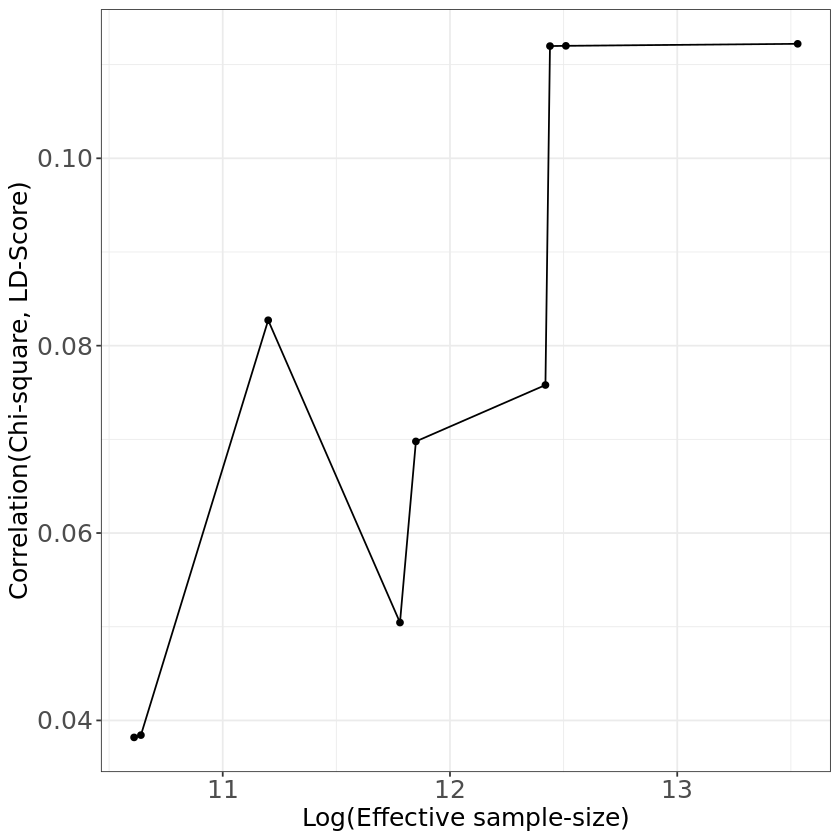

In [31]:
#Plotting
effective_sample_sizes <- c(neffective_diamante18_EUR, neffective_diamante22_EUR, neffective_diamante22_EAS, neffective_diamante22_SAS, neffective_t2dggi_AFR, neffective_t2dggi_AMR, neffective_t2dggi_EAS, neffective_t2dggi_EUR, neffective_t2dggi_SAS)
effective_sample_sizes <- round(log(effective_sample_sizes), digits = 2)
correlation_values <- c(diamante18_EUR_cor, diamante22_EUR_cor, diamante22_EAS_cor, diamante22_SAS_cor, t2dggi_AFR_cor, t2dggi_AMR_cor, t2dggi_EAS_cor, t2dggi_EUR_cor, t2dggi_SAS_cor) 
ancestry <- c("European", "European", "East-Asian", "South-Asian", "African", "Hispanic", "East-Asian", "European", "South-Asian")
study <- c("DIAMANTE-18", "DIAMANTE-22", "DIAMANTE-22", "DIAMANTE-22", "T2DGGI", "T2DGGI", "T2DGGI", "T2DGGI", "T2DGGI")
df.plot <- data.frame(effective_sample_sizes, correlation_values, ancestry, study)
ggplot(data=df.plot, aes(x=effective_sample_sizes, y=correlation_values, group=1)) + 
  xlab("Log(Effective sample-size)") + ylab("Correlation(Chi-square, LD-Score)") +
  geom_line(color="black") +
  geom_point() + theme_bw() +
  theme(plot.title = element_text(size=20), axis.text = element_text(size = 15), legend.position = c(0.70, 0.90), legend.text = element_text(size = 15), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank())

png 
  2

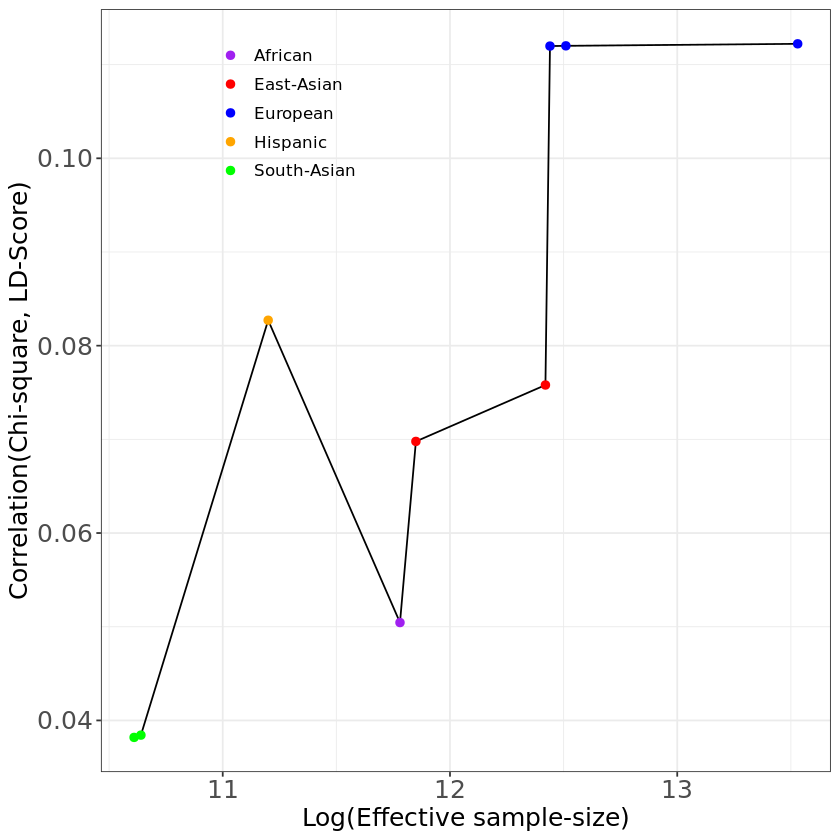

In [38]:
# Generate the plot
ggplot(data = df.plot, aes(x = effective_sample_sizes, y = correlation_values, color = ancestry, group = 1)) + 
  xlab("Log(Effective sample-size)") + 
  ylab("Correlation(Chi-square, LD-Score)") +
  geom_line(color = "black") +
  geom_point(size = 2) + 
  theme_bw() +
  scale_color_manual(values = c("European" = "blue", 
                                "East-Asian" = "red", 
                                "South-Asian" = "green", 
                                "African" = "purple", 
                                "Hispanic" = "orange")) +
  theme(
    plot.title = element_text(size = 20), 
    axis.text = element_text(size = 15), 
    legend.position = c(0.25, 0.87), 
    legend.text = element_text(size = 10), 
    legend.title = element_blank(), 
    axis.title = element_text(size = 15), 
    legend.key = element_blank(), 
    legend.background = element_blank()
  )
plot3 <- ggplot(data = df.plot, aes(x = effective_sample_sizes, y = correlation_values, color = ancestry, group = 1)) + 
  xlab("Log(Effective sample-size)") + 
  ylab("Correlation(Chi-square, LD-Score)") +
  geom_line(color = "black") +
  geom_point(size = 2) + 
  theme_bw() +
  scale_color_manual(values = c("European" = "blue", 
                                "East-Asian" = "red", 
                                "South-Asian" = "green", 
                                "African" = "purple", 
                                "Hispanic" = "orange")) +
  theme(
    plot.title = element_text(size = 20), 
    axis.text = element_text(size = 15), 
    legend.position = c(0.25, 0.87), 
    legend.text = element_text(size = 10), 
    legend.title = element_blank(), 
    axis.title = element_text(size = 15), 
    legend.key = element_blank(), 
    legend.background = element_blank()
  )
#saving plot as .pdf
pdf("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/figure_1_new.pdf", 
    width = 3.9, height = 5.9)
print(plot3)
dev.off() 

In [67]:
plot3 <- ggplot(data = df.plot, aes(x = effective_sample_sizes, y = correlation_values, color = ancestry, group = 1)) + 
  xlab("Log(Effective sample-size)") + 
  ylab("Correlation(Chi-square, LD-Score)") +
  geom_line(color = "black") +
  geom_point(size = 3) + 
  theme_bw() +
  scale_color_manual(values = c("European" = "blue", 
                                "East-Asian" = "red", 
                                "South-Asian" = "green", 
                                "African" = "purple", 
                                "Hispanic" = "orange")) +
  theme(
    plot.title = element_text(size = 20), 
    axis.text = element_text(size = 20), 
    legend.position = c(0.20, 0.85), 
    legend.text = element_text(size = 15), 
    legend.title = element_blank(), 
    axis.title = element_text(size = 20), 
    legend.key = element_blank(), 
    legend.background = element_blank(),
      # Reduce vertical spacing between legend items
    legend.spacing.y = unit(0.07, "cm"),
    legend.key.height = unit(0.07, "cm"),
    
#     # Add top and bottom margins to center square plot in taller canvas
     plot.margin = unit(c(1.0, 1.0, 1.0, 1.0), "cm")  # top, right, bottom, left
  )

# Save as PDF with fixed size
pdf("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/figure_1_new.pdf", 
    width = 4, height = 4)

print(plot3)
dev.off()

# ggsave(
#   filename = "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/figure_1_new.png",
#   plot = plot3,
#   width = 4, height = 4,  # inches; keep square shape
#   units = "in",
#   dpi = 600,
#   device = "png"
# )

# Save the plot
png("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/figure_1_new.png", width = 4000, height = 4000, res = 600)
print(plot3)
dev.off()

# Save the plot
png("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/figure_1_new_2.png", width = 5000, height = 5000, res = 600)
print(plot3)
dev.off()

png 
  2

png 
  2

png 
  2

In [33]:
df.plot

effective_sample_sizes,correlation_values,ancestry,study
<dbl>,<dbl>,<chr>,<chr>
12.51,0.11200327,European,DIAMANTE-18
12.44,0.11197806,European,DIAMANTE-22
11.85,0.06978136,East-Asian,DIAMANTE-22
10.61,0.03818837,South-Asian,DIAMANTE-22
11.78,0.05044570,African,T2DGGI
11.20,0.08271508,Hispanic,T2DGGI
12.42,0.07580101,East-Asian,T2DGGI
13.53,0.11221876,European,T2DGGI
10.64,0.03843171,South-Asian,T2DGGI
